In [18]:
# --- config you can tweak ---
MIN_POINTS = 3              # require at least 3 readings in the last 5 days
KG_PER_MONTH = -2.0         # target pace
AVG_MONTH_DAYS = 30.44      # for kg/day conversion

import pandas as pd

# Load & clean
df = pd.read_csv("weight_log.csv")
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["weight_kg"] = pd.to_numeric(df["weight_kg"], errors="coerce")
df = df.dropna(subset=["date", "weight_kg"]).sort_values("date")

# Use date as index for time-based rolling windows
df = df.set_index("date").sort_index()

# Time-based 5-day window
roll_mean = df["weight_kg"].rolling("5D", min_periods=1).mean()
roll_count = df["weight_kg"].rolling("5D", min_periods=1).count()

# Enforce: (a) at least 5 calendar days elapsed from first reading,
#          (b) at least MIN_POINTS readings in window
first_date = df.index.min()
full_window_start = first_date + pd.Timedelta(days=4)  # first date with a full 5-day span

valid_mask = (df.index >= full_window_start) & (roll_count >= MIN_POINTS)
df["rolling_5d_time"] = roll_mean.where(valid_mask)

# First valid point where the average is allowed to appear
first_valid_label = df.index[valid_mask.argmax()] if valid_mask.any() else None

# Target line (−2 kg/month) anchored at the first valid 5-day average
target = None
if first_valid_label is not None and pd.notna(df.loc[first_valid_label, "rolling_5d_time"]):
    start_weight = df.loc[first_valid_label, "rolling_5d_time"]
    kg_per_day = KG_PER_MONTH / AVG_MONTH_DAYS
    target = (
        df.loc[first_valid_label:, []]
        .copy()
        .assign(target_weight=lambda x: start_weight + (x.index - first_valid_label).days * kg_per_day)
        .reset_index(names="date")
    )

# Back to column form for plotting
df = df.reset_index()


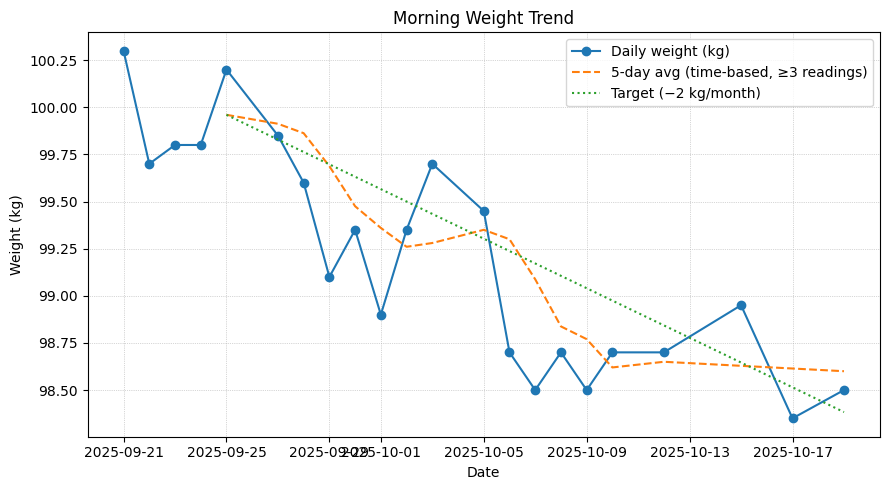

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(9, 5))

# Daily measurements
ax.plot(df["date"], df["weight_kg"], marker="o", label="Daily weight (kg)")

# 5-day time-based average (only where valid_mask was true)
valid_avg = df["rolling_5d_time"].notna()
if valid_avg.any():
    ax.plot(df.loc[valid_avg, "date"], df.loc[valid_avg, "rolling_5d_time"],
            linestyle="--", label=f"5-day avg (time-based, ≥{MIN_POINTS} readings)")

# Target (−2 kg/month)
if target is not None:
    ax.plot(target["date"], target["target_weight"],
            linestyle=":", label="Target (−2 kg/month)")

ax.set_title("Morning Weight Trend")
ax.set_xlabel("Date")
ax.set_ylabel("Weight (kg)")
ax.grid(True, which="both", linestyle=":", linewidth=0.5)
ax.legend()

fig.tight_layout()
fig.savefig("weight_trend.png", dpi=150)
